# Partial dependence plot explainer

In [4]:
from mercury.explainability.explainers import PartialDependenceExplainer

In [5]:
from pyspark.sql import SparkSession
import pyspark.ml.regression as pysparkreg
import pyspark.ml.classification as pysparkclas
from pyspark.ml.feature import VectorAssembler
import pyspark

In [6]:
sess = SparkSession.builder.config("k1", "v1").getOrCreate()

## 1. Introduction

This notebook shows four examples on how to use Mercury's Partial Dependence Explainer functionality. This explainer takes your model and studies how varying each feature (one at a time) affects the output. This is helpful when trying to identify which features affect the most the outputs and also in what way.

We will make use of two datasets:

1. Iris. For multiclassification problems.
2. California Houses. For regression type problems. (Note that binary classification can be also thought as a regression task in terms of the explanation).

For each one of them, we will fit a random forest using Sklearn and PySpark's ML and then, we will use the explainer to explore the model behaviour.

Let us start by loading the datasets and making four dataframes (two on spark and two on pandas).

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from sklearn.datasets import fetch_california_housing, load_iris

We prepare two Pandas dataframes with the data

In [9]:
iris = load_iris()
houses = fetch_california_housing()

houses_pd_df = pd.DataFrame(houses['data'], columns=houses['feature_names'])
houses_pd_df['target'] = houses['target']

iris_pd_df = pd.DataFrame(iris['data'], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
iris_pd_df['target'] = iris['target']

We also should create copies on spark for later...

In [10]:
houses_sp_df = sess.createDataFrame(houses_pd_df)
iris_sp_df = sess.createDataFrame(iris_pd_df)

## 2. Explain "standard python" models

In this section, we will explore Random Forests built with sklearn. One for the Iris dataset and other for the Houses dataset.

In [11]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

### Iris dataset (Multiclass problem)

TLDR: This dataset has four features containing data of flower measures and the task consists on predicting the class type of the flower. Hence, the target of our RF will model a multinomial distribution on the classes

We fit our model:

In [12]:
rf = RandomForestClassifier().fit(iris_pd_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']], 
                                  iris_pd_df['target'])

Here we create our explainer. The workflow is pretty simple. It first needs a reference to a function performing the inference task. Because this is a classification problem we need probabilities, and, because we are modelling 4 classes, we simply pass `rf.predict_proba` method, which will take the data and output a 4-component vector for each instance.

Note that the provided function must take a DataFrame with **ONLY** the needed features for inference. So if you have other columns for temporal variables, metadata or targets, you should drop them before calling `explainer.explain`

In [13]:
explainer = PartialDependenceExplainer(rf.predict_proba)

# We need a dataset with only features
features = iris_pd_df.loc[:, ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
explanation = explainer.explain(features)

The explainer will return  a PartialDependenceExplanation object which holds the functionality for plotting the results.

Now, we can make a plot of all the features showing only the 5th-95th quantile range for the 3rd Class:

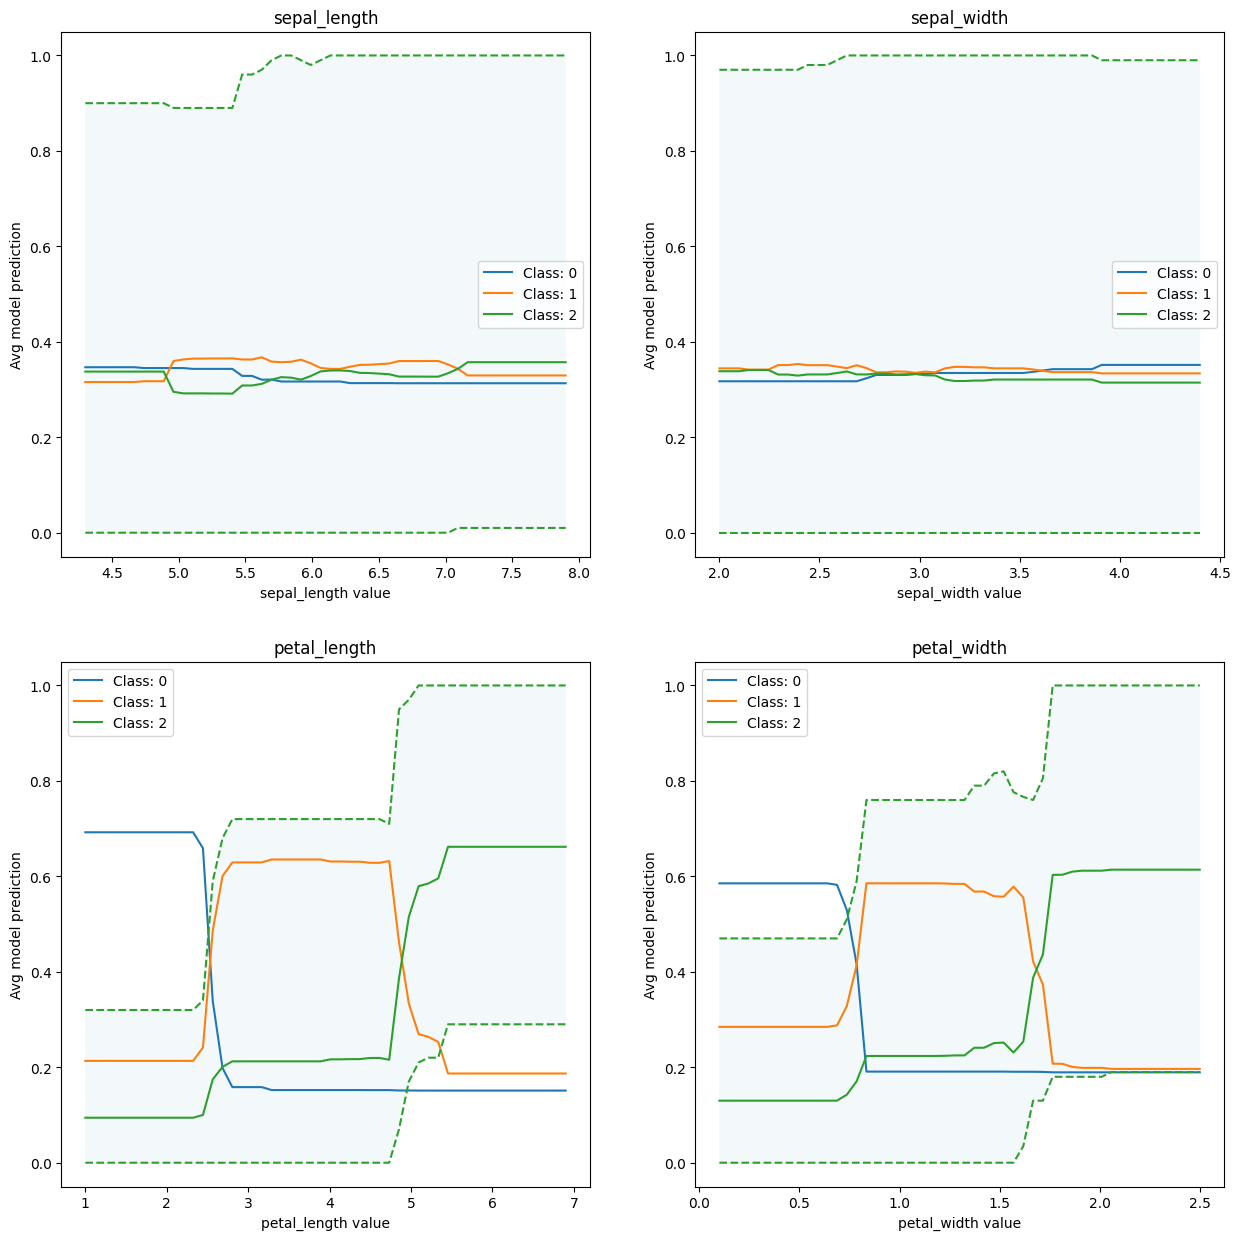

In [14]:
explanation.plot(ncols=2, quantiles=[False, False, True])

Or simply one in case we want to include it in a custom figure (without showing quantiles)

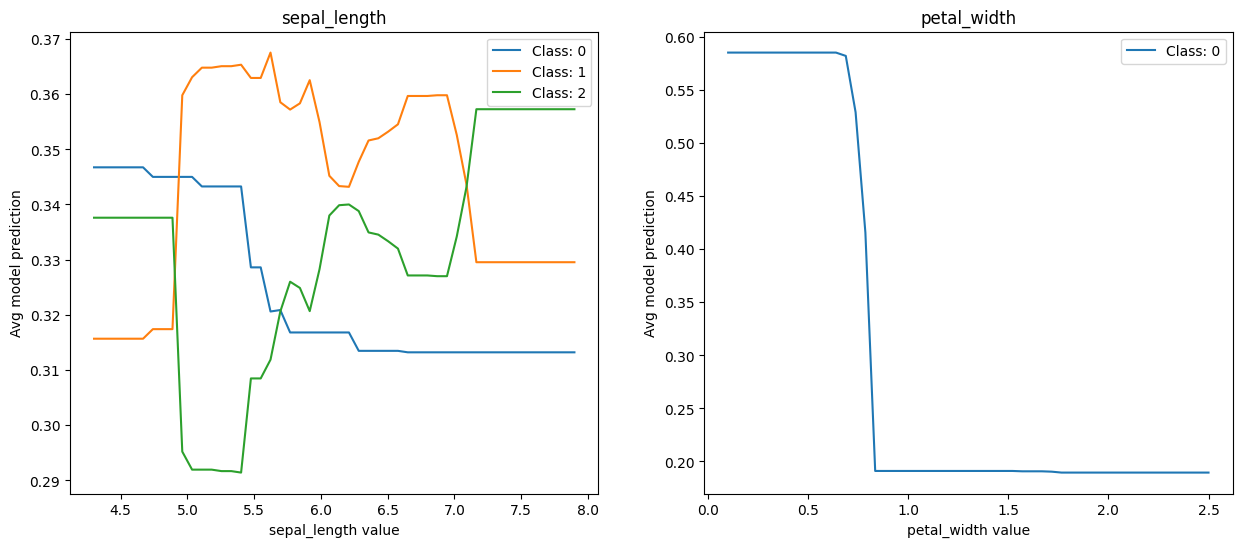

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
explanation.plot_single('sepal_length', ax=ax[0])

# Single plot but only with the class 0 (filter is useful if we have lots of classes).
explanation.plot_single('petal_width', ax=ax[1], filter_classes=[True,False,False])

### Houses dataset (Regresion problem)

In this section we will perform a similar workflow but for a regression task. In this case we only have a single real target 

In [16]:
# Fit the model
rf = RandomForestRegressor().fit(houses_pd_df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup','Latitude', 'Longitude']], 
                                 houses_pd_df['target'])

In [17]:
# Note we pass rf.predict instead of rf.predict_proba
explainer = PartialDependenceExplainer(rf.predict, verbose=True)

In this case, we can tell the explainer not to run the computation of certain features. This is useful for saving time if we don't care about the marginal effect of one feature.

In [18]:
# Dataset with ONLY the features required for inference
features = houses_pd_df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup','Latitude', 'Longitude']]

In [19]:
explanation = explainer.explain(features, ignore_feats=['HouseAge', 'AveBedrms', 'Population'])

Starting calculation for feature MedInc - Type: continuous
	Value range to test: [0.4999, 15.0001] (only on 50 items)
Partial dependence for feature MedInc calculated. Took 10.37 seconds
Starting calculation for feature AveRooms - Type: continuous
	Value range to test: [0.8461538461538461, 141.9090909090909] (only on 50 items)
Partial dependence for feature AveRooms calculated. Took 18.87 seconds
Starting calculation for feature AveOccup - Type: continuous
	Value range to test: [0.6923076923076923, 1243.3333333333333] (only on 50 items)
Partial dependence for feature AveOccup calculated. Took 17.10 seconds
Starting calculation for feature Latitude - Type: continuous
	Value range to test: [32.54, 41.95] (only on 50 items)
Partial dependence for feature Latitude calculated. Took 18.14 seconds
Starting calculation for feature Longitude - Type: continuous
	Value range to test: [-124.35, -114.31] (only on 50 items)
Partial dependence for feature Longitude calculated. Took 17.84 seconds


Again, we make a plot of the feature effects with the 5th-95th quantile range for the average model prediction.

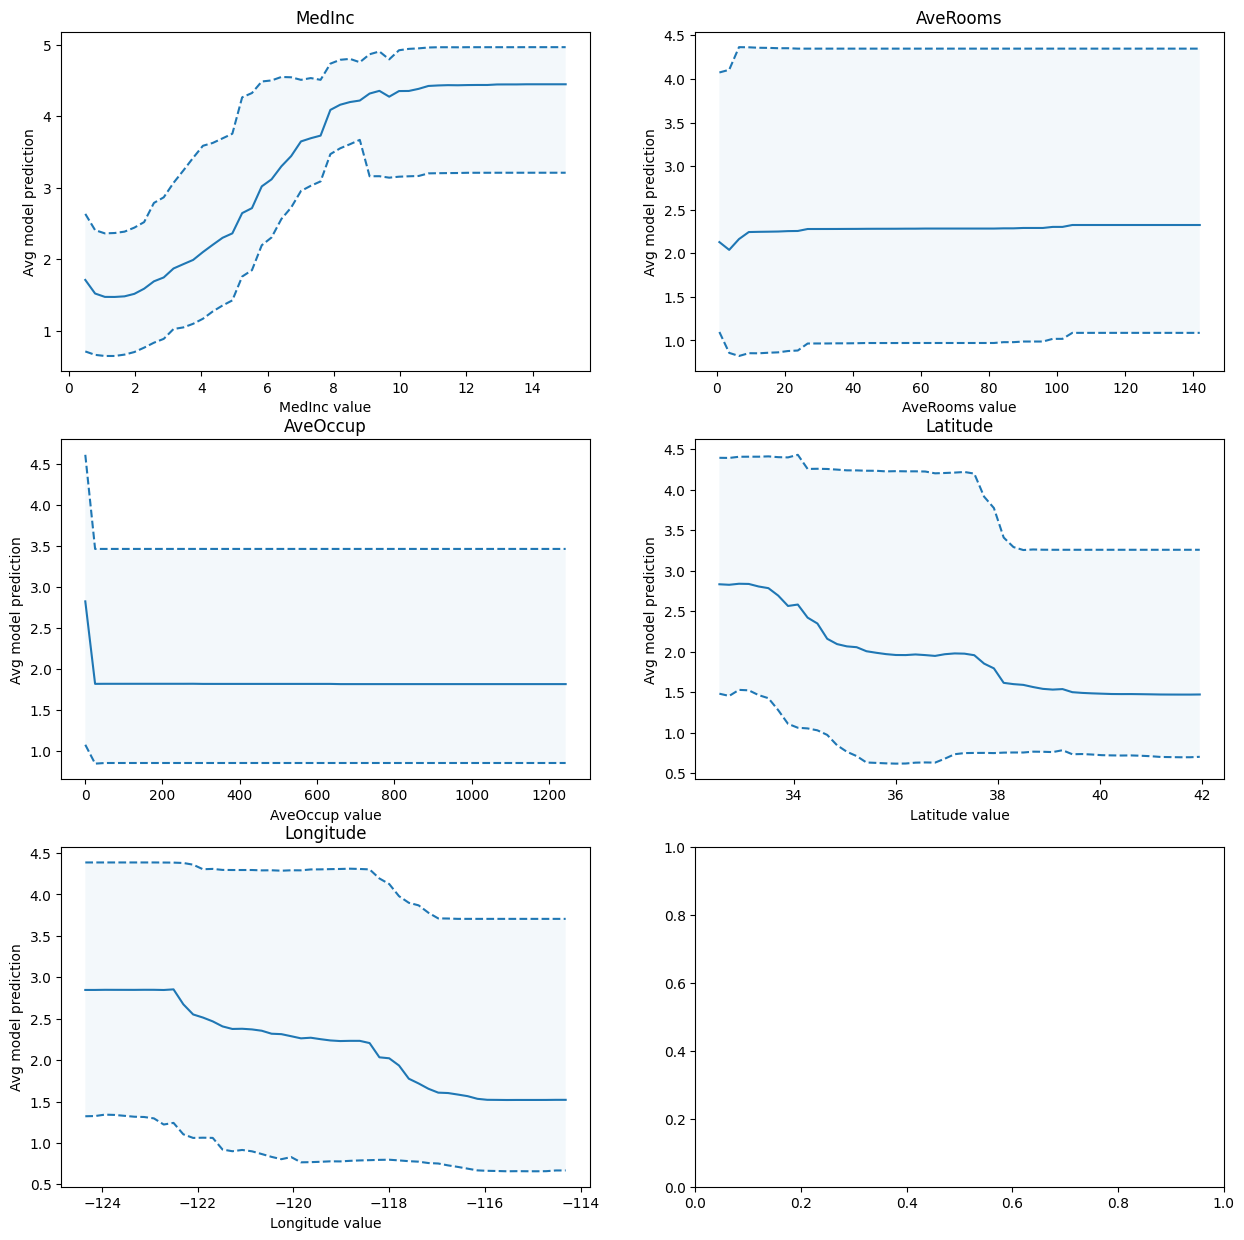

In [20]:
explanation.plot(ncols=2, quantiles=True)

## 3. Explain Pyspark models

This section covers the same as [2] but using PySpark Random Forests instead of Sklearn ones.

### Iris

Pyspark ML models usually work with Vectors instead of directly columns, so we'll need to make a VectorAssembler (or similar) in order to take the desired columns and build the model's input.

In [21]:
assembler = VectorAssembler(inputCols=['sepal_length','sepal_width','petal_length','petal_width'], 
                            outputCol='features')
iris_sp_df = assembler.transform(iris_sp_df)

Fit the model. In this case, It will take a column with the transformded features (as a Vector) and will add several columns to the dataframe (once we call `.transform`)

In [22]:
rf = pysparkclas.RandomForestClassifier(
    featuresCol="features",
    labelCol="target"
).fit(iris_sp_df)

In the case of pyspark models, we can't simply pass a `model.transform` because on each iteration we will need to alter each feature, and therefore, we will need to assemble a new Vector column with the perturbed features.

So we will make a function which takes the dataset with the features, applies our VectorAssembler first, creating a `features` column and then, calling our model's transform method (which can also be applied for custom Pipelines).

Note that in the case of PySpark models, we also need to tell the explainer the name of the column which will hold the prediction of the model (`output_col` in the constructor). Usually (unless you specify other custom name) it will be `probability` for classification tasks and `prediction` for regression tasks.

In [23]:
def my_pred_fn(data):
    temp_df = assembler.transform(data)
    return rf.transform(temp_df)
    
# Note that we also need to provide the name of the model's output column.
# Also, this time we skip computing quantiles to save time.
explainer = PartialDependenceExplainer(my_pred_fn, output_col='probability', quantiles=False)

In [24]:
# We prepare the dataset with ONLY the features needed by the model
iris_features = iris_sp_df.drop("features").drop('target')

In [25]:
# We ignore two features for the computations to save time
explanation = explainer.explain(iris_features, ignore_feats=['petal_length','petal_width'])

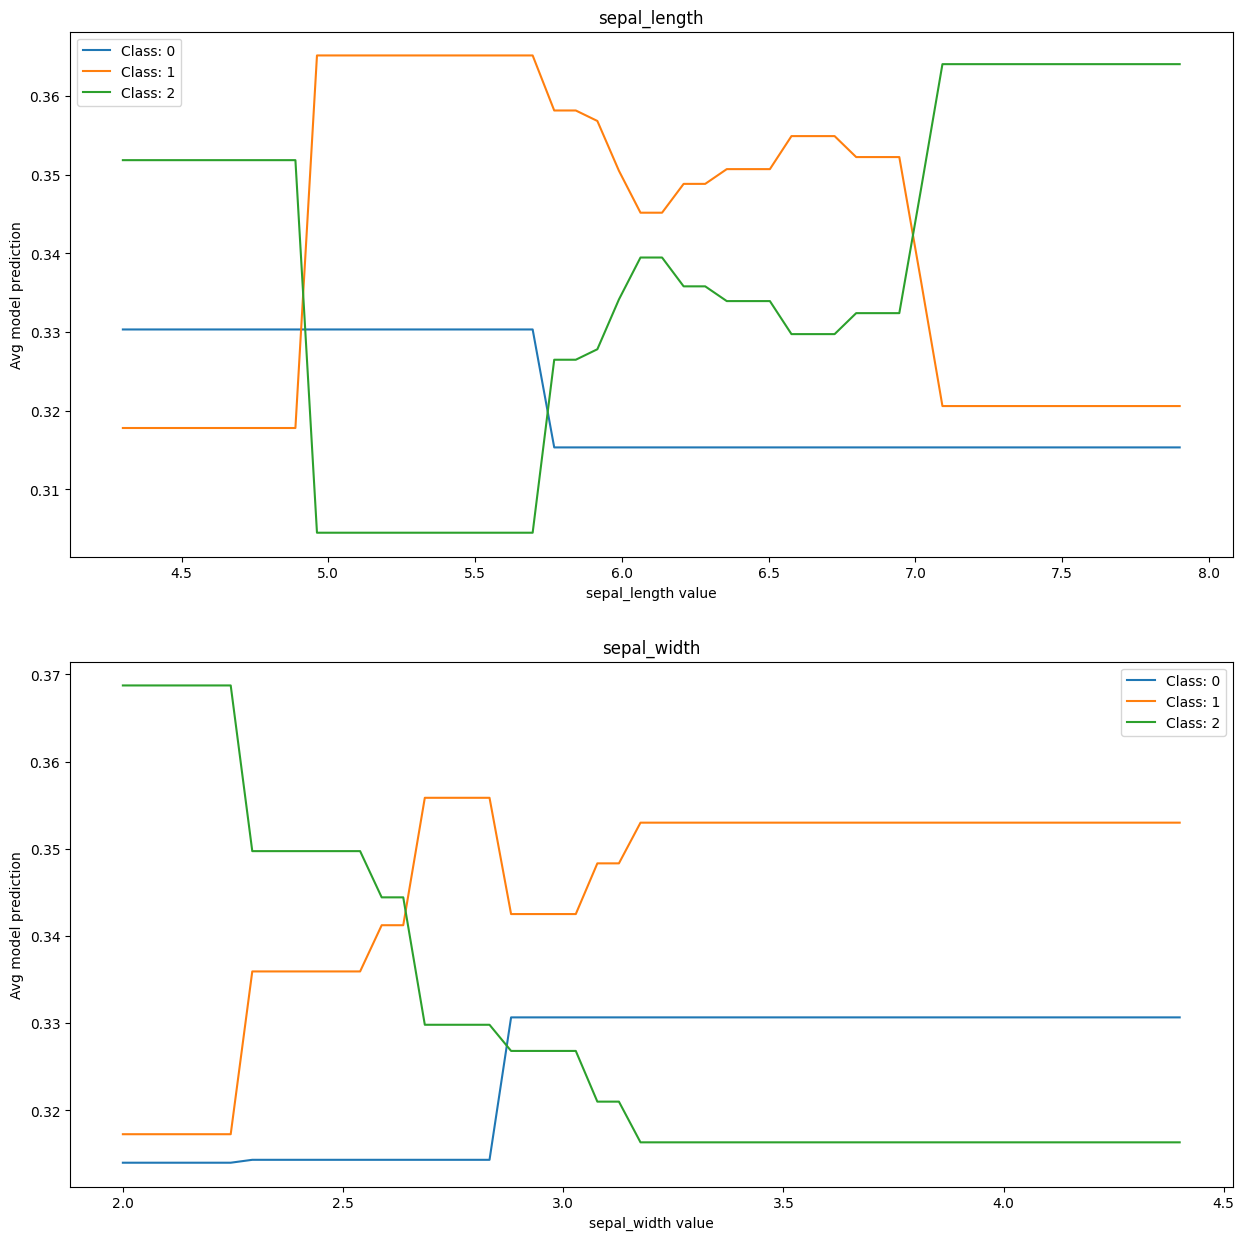

In [26]:
explanation.plot()

### Houses (Regresion)

This example shows how to use the explainer on Regression tasks.

The main difference with the Pyspark Iris example is that we want to predict a single real number instead of a probability distribution.

In [27]:
assembler = VectorAssembler(inputCols=['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude'], 
                            outputCol='features')
houses_sp_df = assembler.transform(houses_sp_df)

In [28]:
rf = pysparkreg.RandomForestRegressor(
    featuresCol="features",
    labelCol="target"
).fit(houses_sp_df)

Note we only changed the `output_col` parameter with the name of the column which will hold the model's predictions.

In [29]:
def my_pred_fn(data):
    temp_df = assembler.transform(data)
    return rf.transform(temp_df)
    
explainer = PartialDependenceExplainer(my_pred_fn, output_col='prediction', verbose=True)

In [30]:
# We prepare our dataset with only features
houses_features = houses_sp_df.drop("features").drop('target')

In [31]:
explanation = explainer.explain(houses_features, ignore_feats=['HouseAge', 'AveBedrms', 'Population'])

Starting calculation for feature MedInc - Type: continuous
	Value range to test: [0.4999, 15.0001] (only on 50 items)
Partial dependence for feature MedInc calculated. Took 46.74 seconds
Starting calculation for feature AveRooms - Type: continuous
	Value range to test: [0.8461538461538461, 141.9090909090909] (only on 50 items)
Partial dependence for feature AveRooms calculated. Took 43.56 seconds
Starting calculation for feature AveOccup - Type: continuous
	Value range to test: [0.6923076923076923, 1243.3333333333333] (only on 50 items)
Partial dependence for feature AveOccup calculated. Took 40.65 seconds
Starting calculation for feature Latitude - Type: continuous
	Value range to test: [32.54, 41.95] (only on 50 items)
Partial dependence for feature Latitude calculated. Took 40.74 seconds
Starting calculation for feature Longitude - Type: continuous
	Value range to test: [-124.35, -114.31] (only on 50 items)
Partial dependence for feature Longitude calculated. Took 39.50 seconds


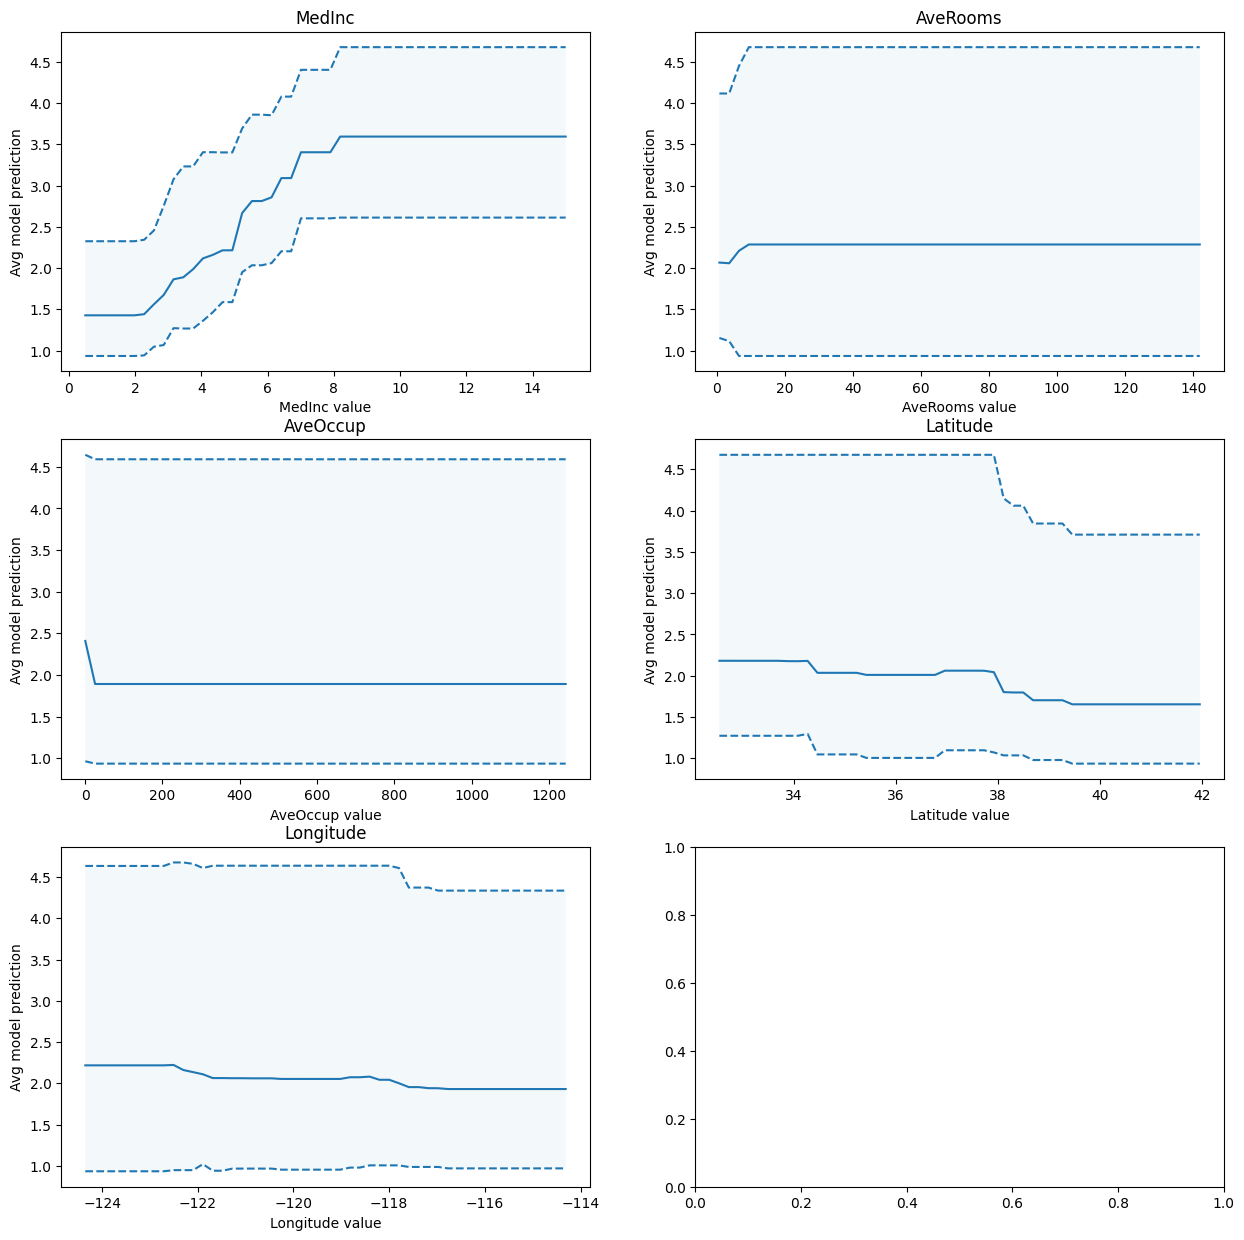

In [32]:
explanation.plot(ncols=2, quantiles=True)